# Introduction

In this paper, a novel analysis is represented which clusters countries based on different measure of their daily Covid-19 cases. This can serve as a tool for different stakeholders confronted with making decisions regarding the Covid-19 cases. 
In addition, a new clustering algorithm approach is developed as a framework for future analysis.

# Set-Up

## Import

In [1]:
import numpy as np #1.23.4
import pandas as pd #1.5.1
import seaborn as sns #0.12.1
import matplotlib.pyplot as plt #3.6.2
import pycountry #22.3.5
import geopandas #0.12.2
import countrynames #1.14.1
import warnings
from geopy.geocoders import Nominatim #2.3.0
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree #1.9.3

## Configure

In [2]:
warnings.filterwarnings('ignore')

## Fetch data

The originial data is from the John-Hopkins university and available via the link provided below. 

For our analysis, the data that contains the Covid-19 data was used, starting from 22nd of January 2020 until 4th of April 2020. Due to the low number of cases before, the 22nd was chosen as a starting date. 

The data contains different measures:
1. Absolute Covid-19 cases
2. Covid-19 cases per 1 million population
3. Covid-19 cases per 1 million population per land area 

Additionally, each of these measures contains the data for each date as well as number of cases, based on the first day when there occured a Covid-19 case in the country. 
These data are labeled as Date or Day, respectively. 

In [3]:
initial_data_url = "https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6"
final_data_url = "https://data.mendeley.com/datasets/kg72dst75p/1"

In [4]:
data_1day = pd.read_csv("../data/Coronavirus_Data_Cases_1a. Per day.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_1date = pd.read_csv("../data/Coronavirus_Data_Cases_1b. Per date.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_2day = pd.read_csv("../data/Coronavirus_Data_Cases_2a. Per day_population.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_2date = pd.read_csv("../data/Coronavirus_Data_Cases_2b. Per date_population.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_5day = pd.read_csv("../data/Coronavirus_Data_Cases_5a. Per day_popul_surf.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_5date = pd.read_csv("../data/Coronavirus_Data_Cases_5a. Per date_popul_surf.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')

## Cleaning Data
### Adjust Data types and columns

In [5]:
def clean_util(dataframe, name, statistics=False):
    if statistics:
        dataframe_with_metric = dataframe.iloc[-4:].copy()
        dataframe = dataframe.iloc[:-5].copy()
    else:
        dataframe_with_metric = dataframe.iloc[0].T.squeeze()
        dataframe = dataframe.iloc[1:].copy()
    dataframe.index.name = name
    if name == 'Date':
        dataframe.index = pd.to_datetime(dataframe.index, format='%d/%m/%Y')
    else:
        dataframe.index = dataframe.index.astype(int)
    return (dataframe, dataframe_with_metric)

def clean_up(dataframe):

    dataframe.dropna(axis=1, how='all', inplace=True)
    dataframe = dataframe.apply(pd.to_numeric, args={'coerce'})
    dataframe.columns = [col.replace('United Kingdom', 'UK') for col in dataframe.columns]

    if type(dataframe.index[0]) != str:
        dataframe.index.name = 'Day'
        return dataframe

    elif 'Density' in dataframe.index[0]  or 'Population' in dataframe.index[0]:
        temp = dataframe.index[1]
        if '/' not in dataframe.index[1]: 
            return clean_util(dataframe, 'Day')
        elif '/' in dataframe.index[1]:
            return clean_util(dataframe, 'Date')
    
    else:
        return clean_util(dataframe, 'Date', statistics=True)


data_1day = clean_up(data_1day)
data_1date, data_1date_metrics = clean_up(data_1date)
data_2day, data_2day_population = clean_up(data_2day)
data_2date, data_2date_population = clean_up(data_2date)
data_5day, data_5day_density = clean_up(data_5day)
data_5date, data_5date_density = clean_up(data_5date)

### Choose relevant columns - truncating data

In [6]:
def truncate_date(data_date):
    last_day = data_date.loc['04/04/2020']
    last_day = last_day.sort_values(ascending=False)
    last_day_high = last_day[:30]
    last_day_low = last_day[-30:]
    data_high = data_date[last_day_high.index]
    data_low = data_date[last_day_low.index]
    return data_high, data_low

def truncate_day(data_day):
    columns = data_day.columns
    data_status = data_day[columns] > 0
    all_days = data_status.all(axis=0)
    countries_complete = columns[all_days]
    countries_uncomplete = columns[~all_days]
    days_recorded = data_status[countries_uncomplete].apply(pd.Series.idxmin)
    days_recorded.sort_values(ascending=False, inplace=True)
    days_recorded_high = days_recorded[:30 - len(countries_complete)]
    days_recorded_low = days_recorded[-30:]
    data_high = data_day[countries_complete | days_recorded_high.index]
    data_low = data_day[days_recorded_low.index]
    return data_high, data_low

data_1date_trunc, data_1date_low = truncate_date(data_1date) 
data_2date_trunc, data_2date_low = truncate_date(data_2date)
data_5date_trunc, data_5date_low = truncate_date(data_5date)
data_1day_trunc, data_1day_low = truncate_day(data_1day)   
data_2day_trunc, data_2day_low = truncate_day(data_2day)
data_5day_trunc, data_5day_low = truncate_day(data_5day)

# 4-step algorithm

- **Step 1:** Keep or disregard terms of the time series in the flattening regime if such regime exists 
- **Step 2:** Calculate all the rates of change for every pair xj{ti}, xj{ti+1}, and find number of day kj when for the first time rate appears to be larger than 20% of the mean value of previous initial rates (that are always small in our time series).
- **Step 3:** For all time series xj{ti} keep terms from i=k...m where k minimum of all kj.
- **Step 4:** Run the agglomerative clustering algorithm with single/complete linkage and Eu-
clidean distance.

## Step 1: Flattening Regime calculation

In [7]:
def new_cases(data):
    df_new_cases = data.diff()
    df_new_cases.iloc[0] = data.iloc[0]
    return df_new_cases 

In [8]:
new_cases_1date = new_cases(data_1date)
new_cases_2date = new_cases(data_2date)
new_cases_5date = new_cases(data_5date)

new_cases_1day = new_cases(data_1day)
new_cases_2day = new_cases(data_2day)
new_cases_5day = new_cases(data_5day)

### Criteria for flattening: Less cases than the days before
Averaged approximation is used to account for outliers and make the flattening calculation more robust  

In [9]:
width_win = 10

mid = width_win // 2

def cut_flattening(data):
    data = new_cases(data)
    flattening_detector = lambda df: df.iloc[:mid].mean() > df.iloc[mid:].mean() 
    temp = data.rolling(window=10, center=True).apply(flattening_detector)
    data[temp == True] = pd.NA
    return data

In [10]:
cutted_1date = cut_flattening(data_1date)
cutted_2date = cut_flattening(data_2date)
cutted_5date = cut_flattening(data_5date)

cutted_1day = cut_flattening(data_1day)
cutted_2day = cut_flattening(data_2day)
cutted_5day = cut_flattening(data_5day)

## Step 2 + 3: Find starting day

In [11]:
inital_days = 7

def step2_3(data, initial_days=inital_days, expanding=True):    
    rates = pd.DataFrame(np.gradient(data, axis=0), index=data.index, columns=data.columns)
    if expanding:
        initial_rates = rates.expanding().mean()
    else:
        initial_rates = pd.DataFrame(0, index=rates.index, columns=rates.columns)
        initial_rates += rates.iloc[:initial_days].mean()
    temp_mask = initial_rates[initial_days:] * 0.2 < rates[initial_days:] 
    min_k_mask = temp_mask.any(axis=1) 
    min_k = min_k_mask.idxmax()
    return min_k 

expd = False
min_k_1date = step2_3(data_1date_trunc, expanding=expd)
min_k_2date = step2_3(data_2date_trunc, expanding=expd)
min_k_5date = step2_3(data_5date_trunc, expanding=expd)
min_k_1day = step2_3(data_1day_trunc, expanding=expd)
min_k_1day = step2_3(data_2day_trunc, expanding=expd)
min_k_1day = step2_3(data_5day_trunc, expanding=expd)

## Agglomerative Clustering

In [12]:
def plot_hierarchy(data, ax, complete=False):
    data = data.T
    if not complete:
        linkage_matrix = linkage(data, method='single', metric='euclidean')
    else:
        linkage_matrix = linkage(data, method='complete', metric='euclidean')
    
    country_names = data.index.to_list()

    def llf(i):
        return '{}---{}'.format(country_names[i], i)

    R = dendrogram(
        linkage_matrix
        , ax=ax
        , orientation='right'
        , leaf_label_func=llf
        , count_sort=True
    )
    ax.set_xticks([])
    return R, pd.DataFrame(linkage_matrix, columns=['cluster1', 'cluster2', 'distance', 'members'])

# Visualizations

## Gradients of 8 selected countries

- China and South Korea show similar qualitative behaviour of decreasing gradient 
- Vietnam and Thailand show first since of a flattening of the courve
- In contrast, all Japan, Singapore, Nepal and US show steep increase in cases gradient  

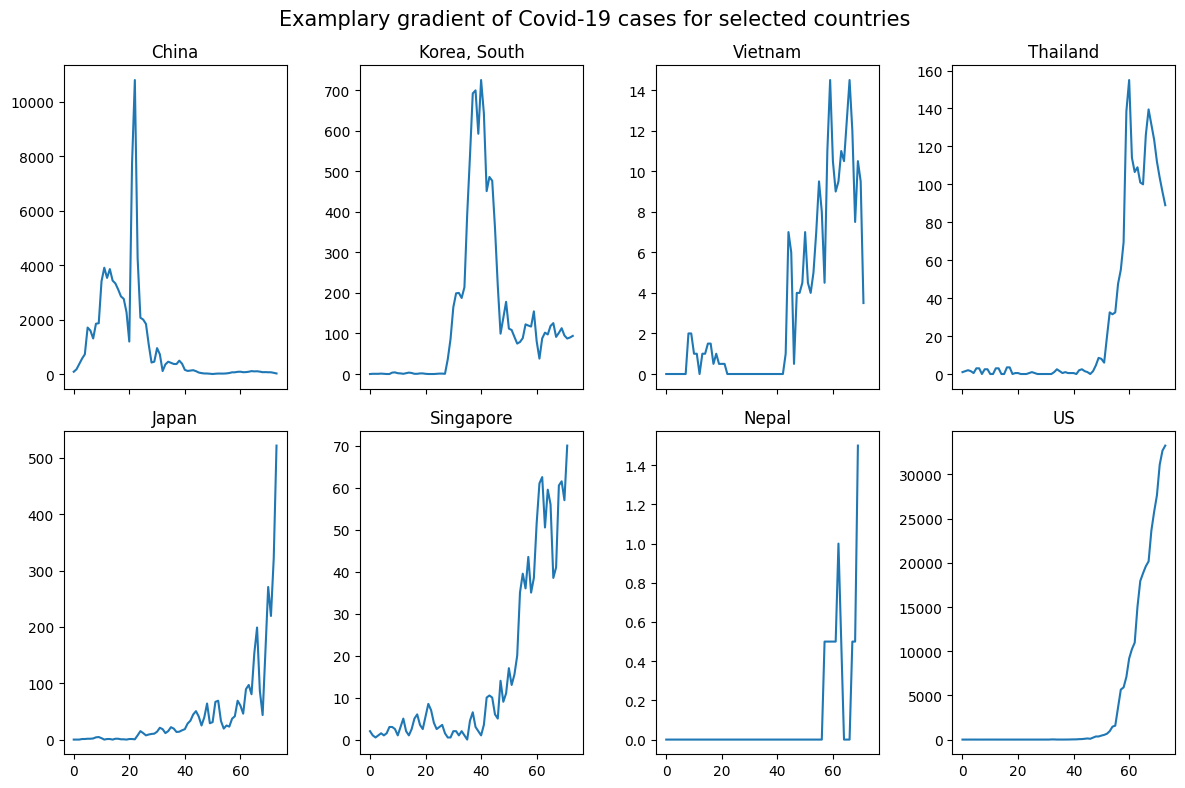

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8), sharex=True)

selected_countries = data_1day[['China', 'Korea, South', 'Vietnam', 'Thailand', 'Japan', 'Singapore', 'Nepal', 'US']]
data_gradient = []
for i, country in enumerate(selected_countries.columns):
    ax = axes.flat[i]
    grad = np.gradient(data_1day[country])
    data_gradient.append(grad)
    ax.plot(grad)
    ax.set_title(country)

fig.suptitle('Examplary gradient of Covid-19 cases for selected countries', fontsize=15)
fig.tight_layout()

fig.savefig('../figures/Examplary_gradient.png')

data_gradient = pd.DataFrame(data_gradient)

### Absolute cases

#### Highest and oldest cases

- China and South Korea show similar behaviour on different levels 
- Some countries with early cases, but still low number of cases until today 
- Others show sharp increase only in the last few days 

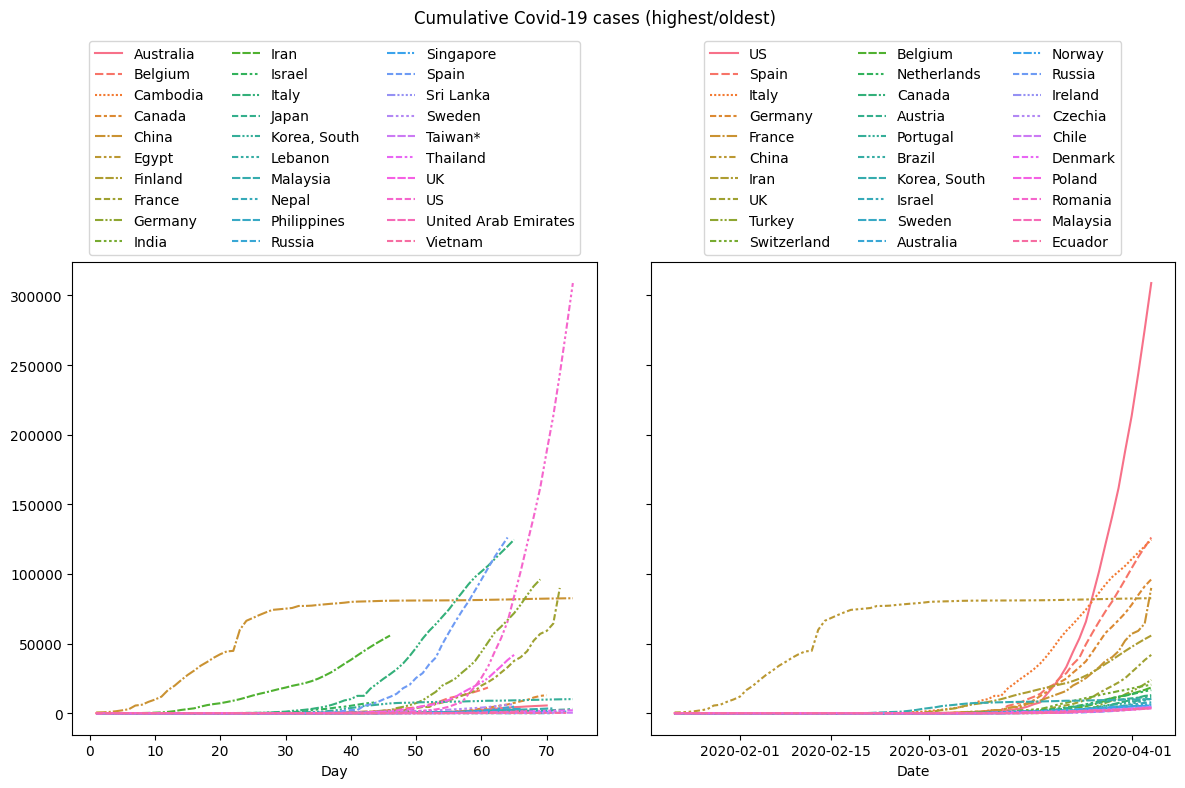

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

sns.lineplot(data=data_1day_trunc, ax=ax1)
sns.lineplot(data=data_1date_trunc, ax=ax2)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)

fig.suptitle('Cumulative Covid-19 cases (highest/oldest)')
fig.tight_layout()

fig.savefig('../figures/Fig1_high.png')

#### Lowest and latest cases

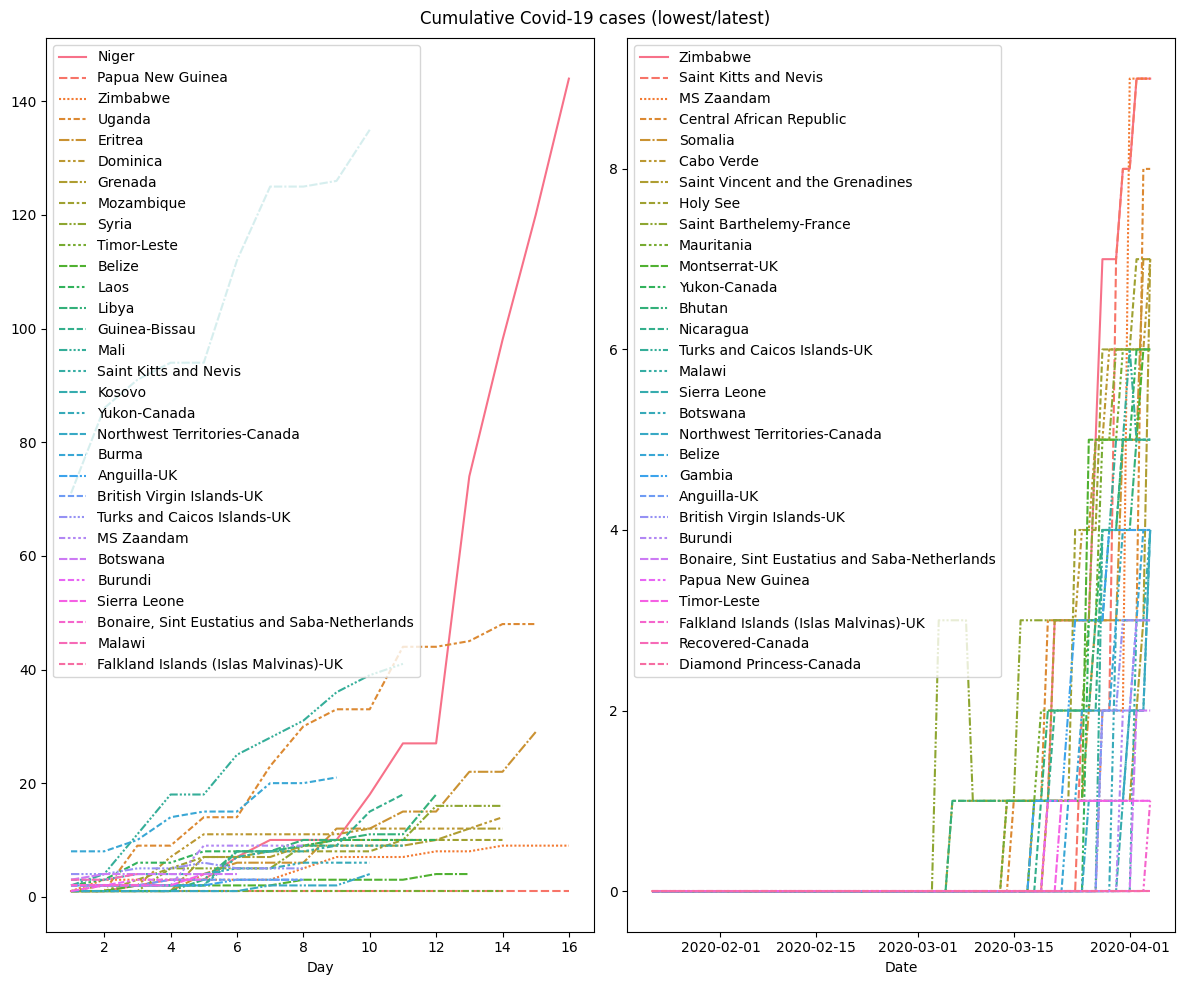

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

sns.lineplot(data=data_1day_low, ax=ax1)
sns.lineplot(data=data_1date_low, ax=ax2)

fig.suptitle('Cumulative Covid-19 cases (lowest/latest)')
fig.tight_layout()

fig.savefig('../figures/Fig1_low.png')

### Clustering absolute cases of day data

The clustering is based on the Day data, containing the first 44 days for each country. 

- China, Iran and Italy separate and each form their own cluster whilst isolating from the other countries 
- Israel, South Korea and Spain build together a cluster by separating from the rest 
- Without these countries, first countries that split up are Germany and Belgium from the rest 
- Sweden, UK and France from own cluster next 
- Lebanon, Egypt and Japan split next 

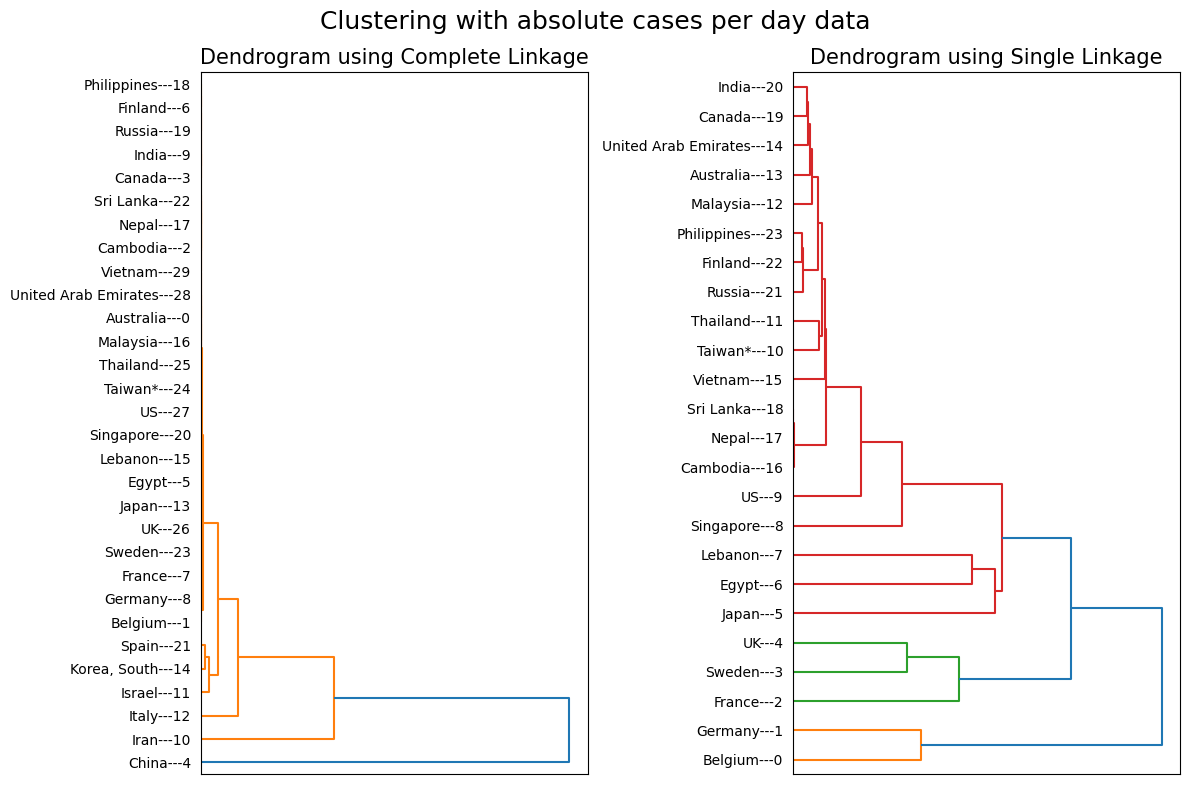

In [16]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=2)

dend1, linkage_matrix1 = plot_hierarchy(data_1day_trunc[:44], ax=axes[0], complete=True)
dend2, linkage_matrix2 = plot_hierarchy(data_1day_trunc.iloc[:44, dend1['leaves'][6:]], ax=axes[1])

axes[0].set_title('Dendrogram using Complete Linkage', fontsize=15)
axes[1].set_title('Dendrogram using Single Linkage', fontsize=15)
fig.suptitle('Clustering with absolute cases per day data', fontsize=18)

fig.tight_layout()

plt.savefig('../figures/Clustering1')

Additionally, the date data is used instead of the day data and gives following results

- US splits up first instead of China this time
- China isolates next
- Germany, Spain and Italy form same cluster in this figure 

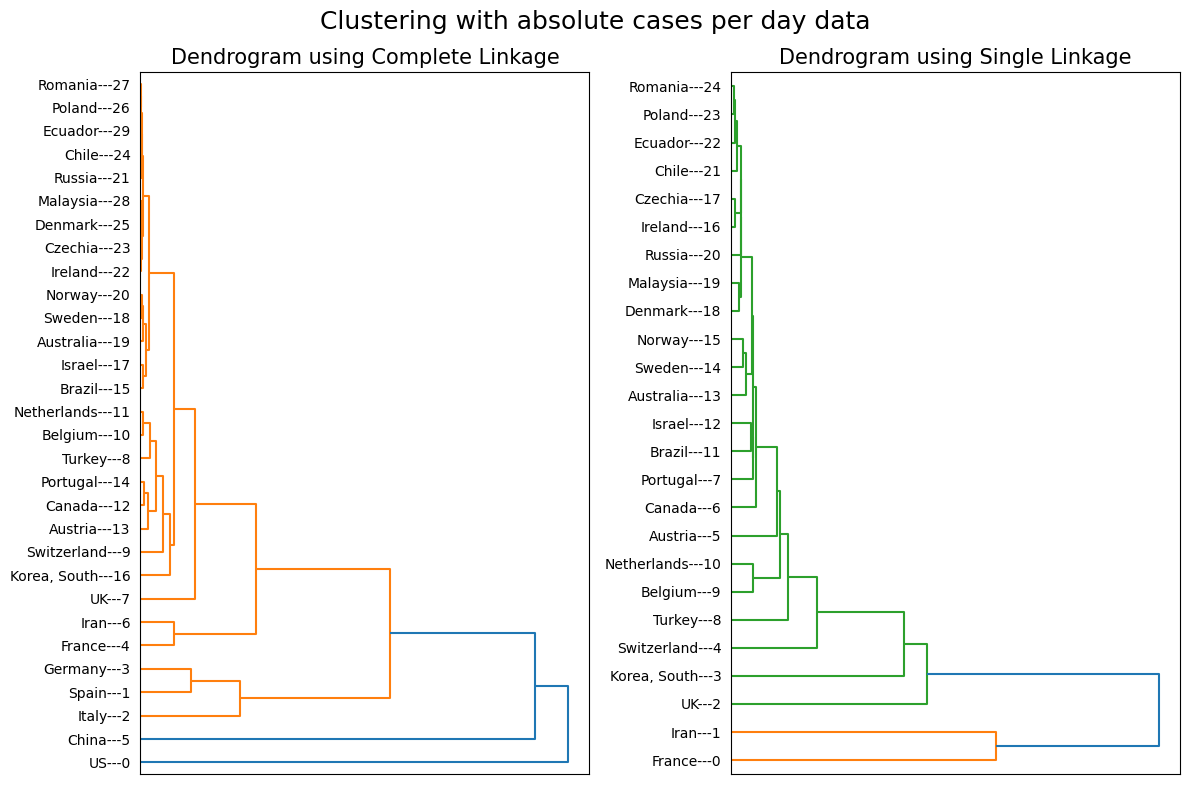

In [17]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=2)

dend1b, linkage_matrix1b = plot_hierarchy(data_1date_trunc, ax=axes[0], complete=True)
dend2b, linkage_matrix2b = plot_hierarchy(data_1date_trunc.iloc[:, dend1b['leaves'][5:]], ax=axes[1])

axes[0].set_title('Dendrogram using Complete Linkage', fontsize=15)
axes[1].set_title('Dendrogram using Single Linkage', fontsize=15)
fig.suptitle('Clustering with absolute cases per day data', fontsize=18)

fig.tight_layout()

plt.savefig('../figures/Clustering1b')

### Cases per 1 million

#### Highest and oldest cases

- Small countries are generally in the leading positions of the number of cases per population, followed by bigger western countries 
- Countries where the cases occured first are not necessarily in a worse position then other countries where the first cases occured later 

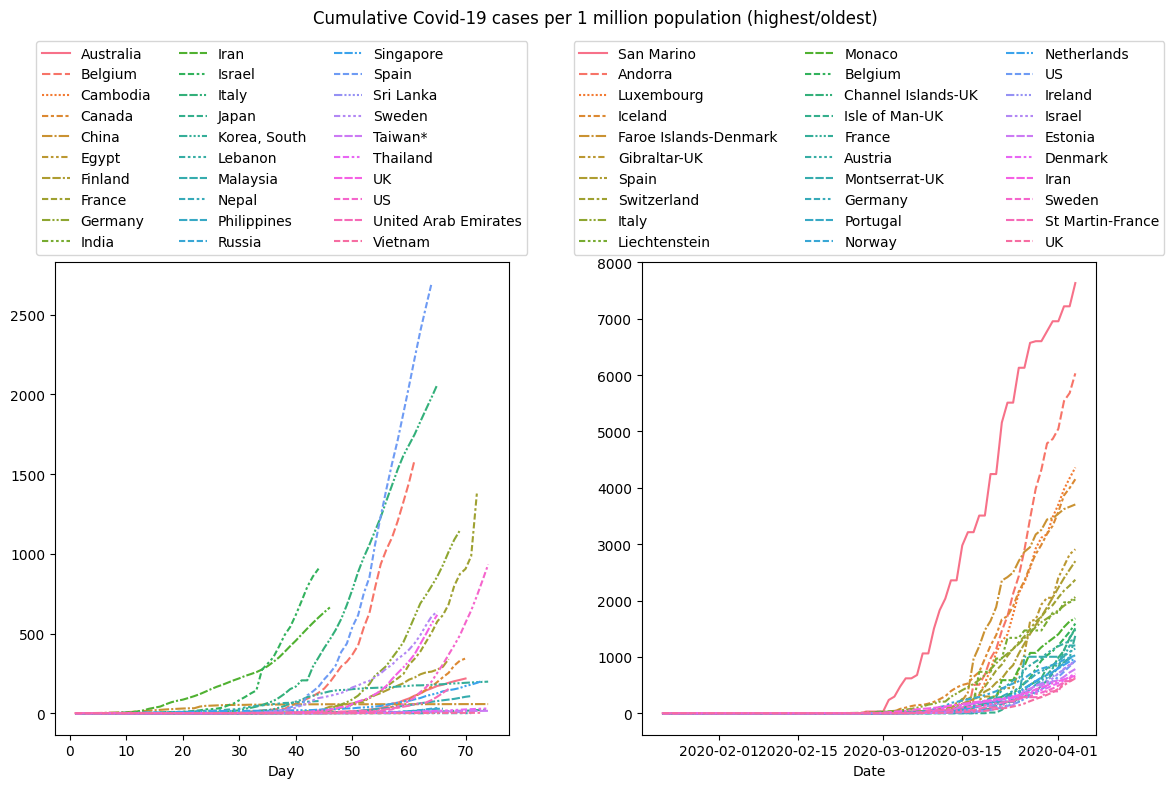

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

sns.lineplot(data=data_2day_trunc, ax=ax1)
sns.lineplot(data=data_2date_trunc, ax=ax2)

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)

fig.suptitle('Cumulative Covid-19 cases per 1 million population (highest/oldest)')
fig.tight_layout()

fig.savefig('../figures/Fig2_high.png')

#### Lowest and latest cases

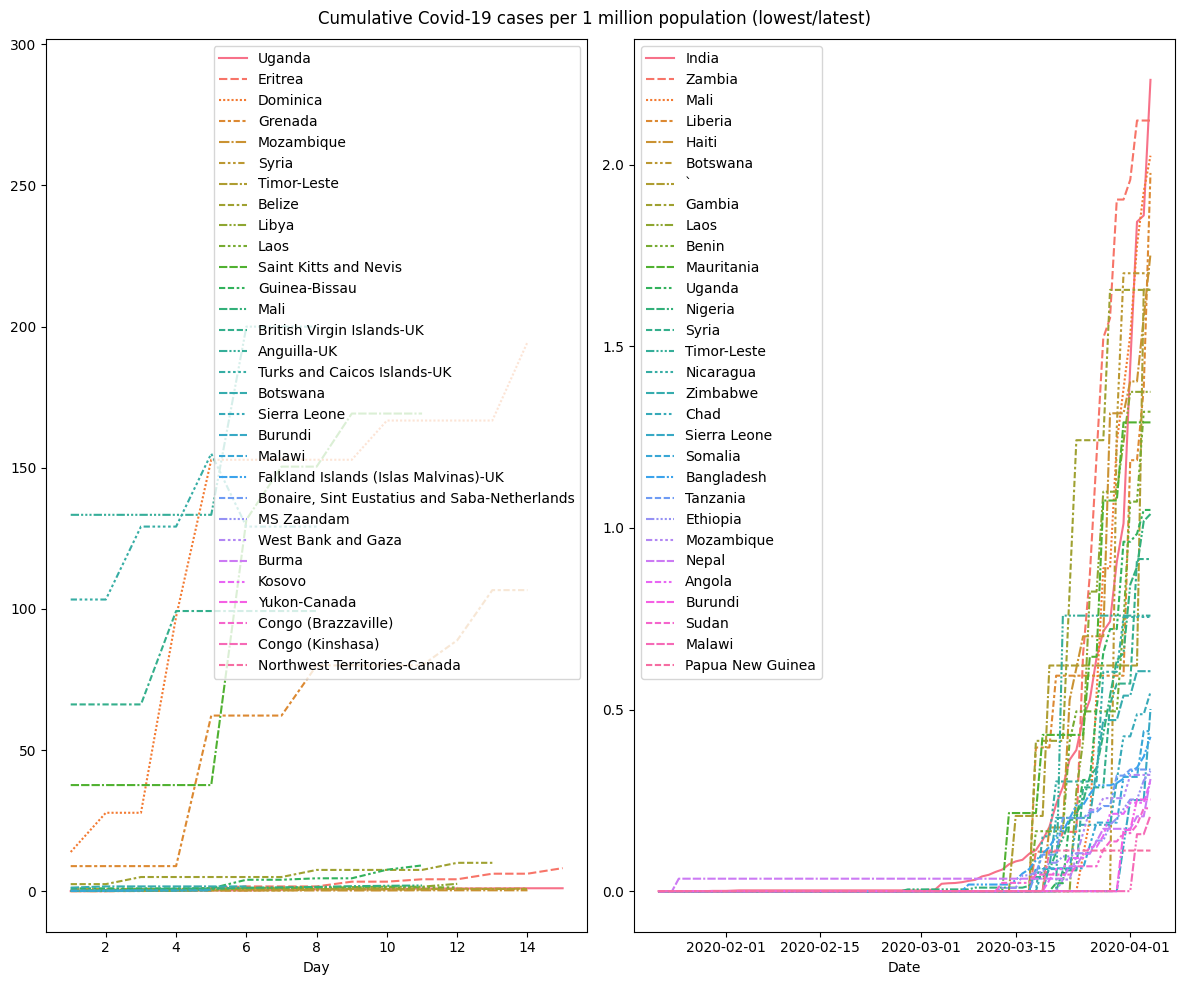

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

sns.lineplot(data=data_2day_low, ax=ax1)
sns.lineplot(data=data_2date_low, ax=ax2)

fig.suptitle('Cumulative Covid-19 cases per 1 million population (lowest/latest)')
fig.tight_layout()

fig.savefig('../figures/Fig2_low.png')

### Clustering cases per population cases on date data

For the following clustering, the date data is used. 

- San Marino isolates first from all the other countries 
- Next, Andorra isolates together with the subcluster of Faroe-Islands Denmark, Luxembourg and Iceland 

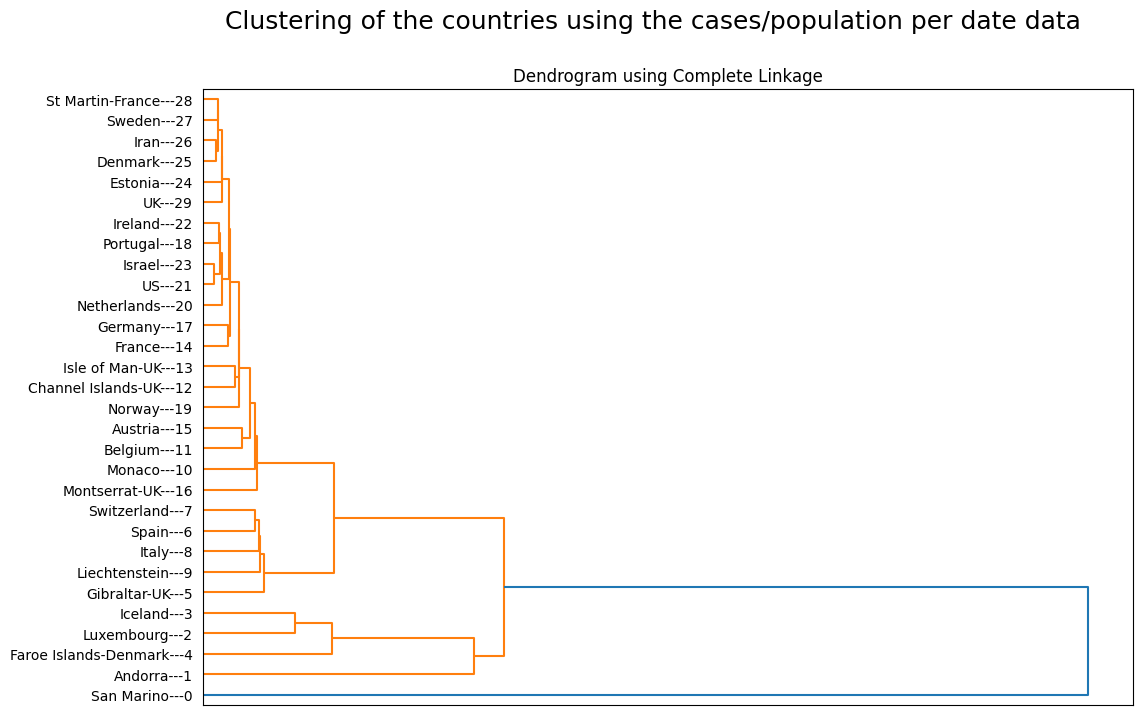

In [20]:
fig, axes = plt.subplots(figsize=(12, 8))

dend3, linkage_matrix3 = plot_hierarchy(data_2date_trunc, ax=axes)

axes.set_title('Dendrogram using Complete Linkage')
fig.suptitle('Clustering of the countries using the cases/population per date data', fontsize=18)

plt.savefig('../figures/Clustering2')

### Cases per population per land

#### Highest and oldest cases

- The leading positions in this case are strongly dominated by small countries with a relatively high density 
- Countries where the cases occured quite early are generally in a better situation than the other countries 

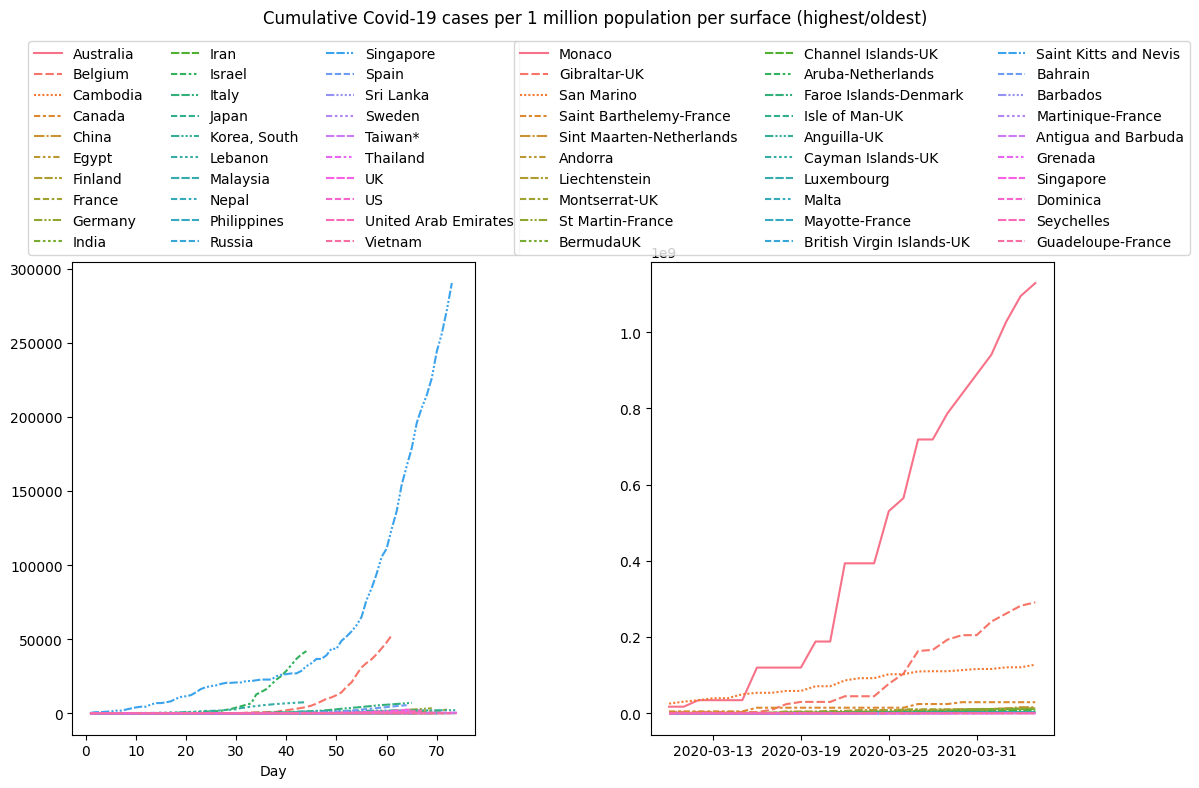

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

sns.lineplot(data=data_5day_trunc, ax=ax1)
sns.lineplot(data=data_5date_trunc.loc[pd.date_range('2020-03-10', '2020-04-04')], ax=ax2)

ax2.xaxis.set_major_locator(plt.MaxNLocator(5))

sns.move_legend(ax1, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)
sns.move_legend(ax2, loc='lower center', bbox_to_anchor = (0.5,1), ncol=3, fancybox=True)

fig.suptitle('Cumulative Covid-19 cases per 1 million population per surface (highest/oldest)')
fig.tight_layout()

fig.savefig('../figures/Fig5_high.png')

#### Lowest and latest cases

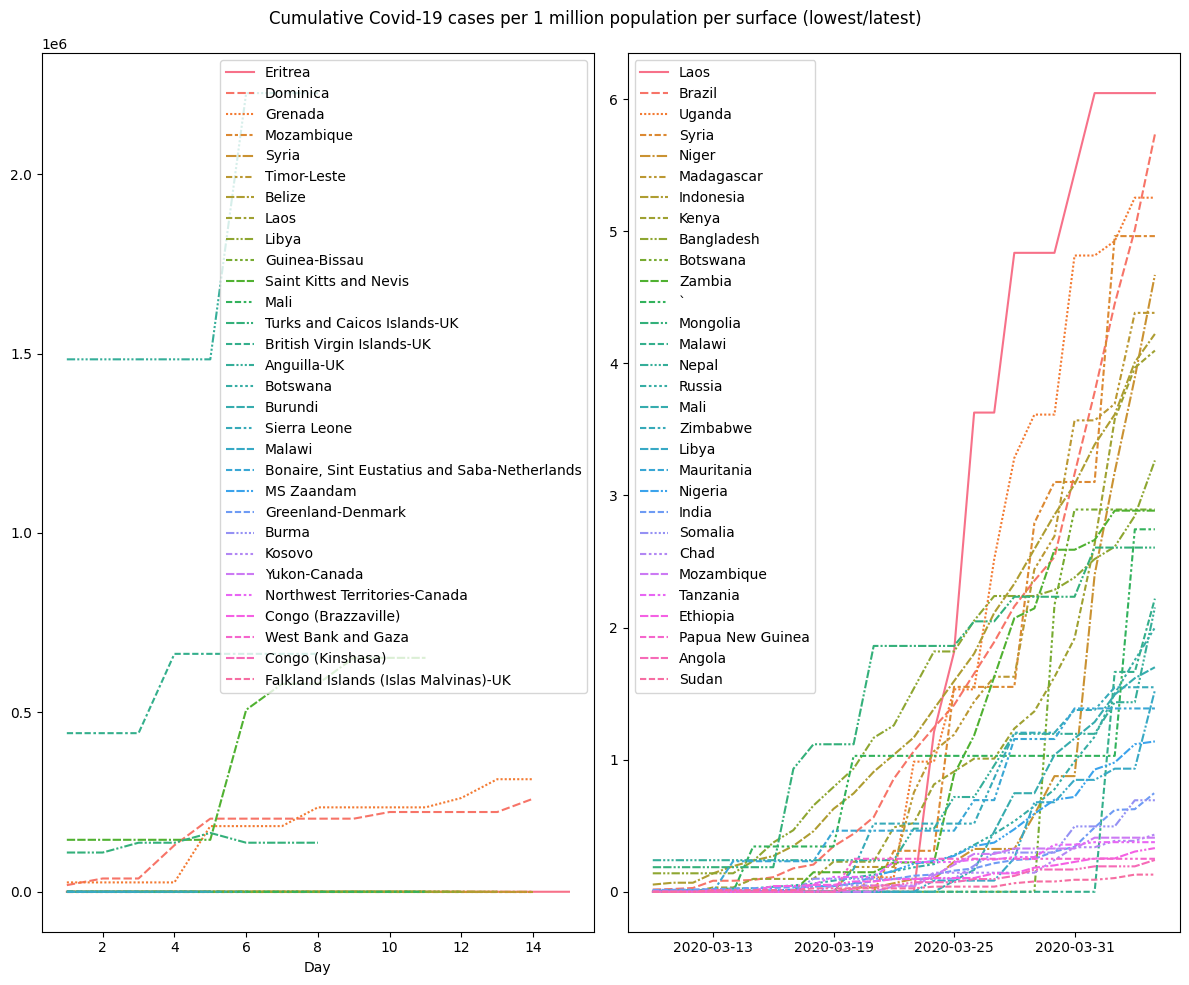

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

sns.lineplot(data=data_5day_low, ax=ax1)
sns.lineplot(data=data_5date_low.loc[pd.date_range('2020-03-10', '2020-04-04')], ax=ax2)

ax2.xaxis.set_major_locator(plt.MaxNLocator(5))

fig.suptitle('Cumulative Covid-19 cases per 1 million population per surface (lowest/latest)')
fig.tight_layout()

fig.savefig('../figures/Fig5_low.png')

### Clustering cases per population per land area on date data

Again, the date data is utilized for the clustering 

- Monaco isolates first from all other countries, followed by Gibraltar-UK, San Marino and Saint Barthelemy-France, respectively
- The right figure shows the remaining split-ups, which form more evenly distributed clusters 

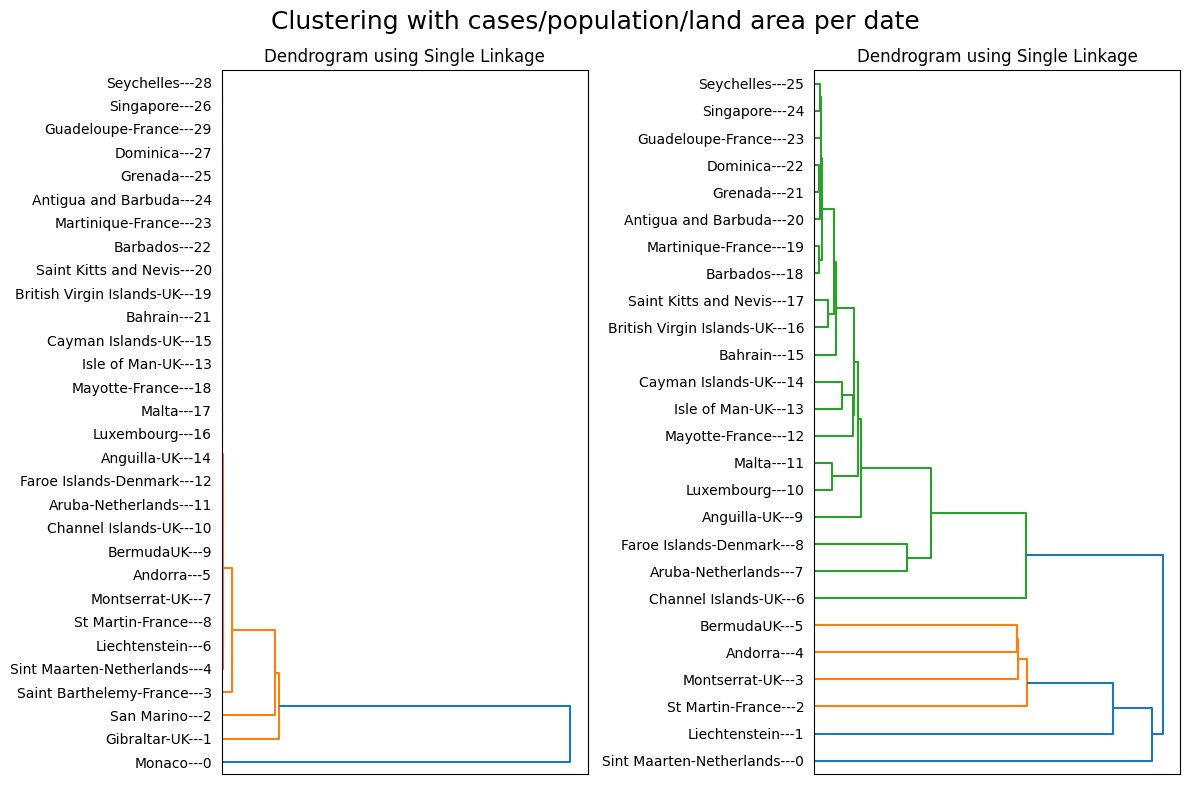

In [23]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=2)

dend4, linkage_matrix4 = plot_hierarchy(data_5date_trunc, ax=axes[0])
dend5, linkage_matrix5 = plot_hierarchy(data_5date_trunc.iloc[:, dend4['leaves'][4:]], ax=axes[1])

fig.suptitle('Clustering with cases/population/land area per date', fontsize=18)
axes[0].set_title('Dendrogram using Single Linkage')
axes[1].set_title('Dendrogram using Single Linkage')

fig.tight_layout()

plt.savefig('../figures/Clustering5')

## Remarks

Some countries we visualised and clusters were not contained in the paper. This applies especially to very small countries. Our clustering results are supported by the raw data. Thus, we suppose there were some countries implicetly excluded in the paper or some artifacts due to the naming of these countries occurred. 

# World map

## Prepare cluster GeoDataFrame 

In [24]:
geolocator = Nominatim(user_agent='covid_data')
def geolocate(country):
    try:
        loc = geolocator.geocode(country)
        return (loc.latitude, loc.longitude)
    except:
        return np.nan

In [25]:
num_clusters = 6
method = 'complete'
metric = 'euclidean'
measure = 'Day'

if measure == 'Day':
    data_world = data_1day_trunc[:44].T.copy() 
else: 
    data_world = data_1date_trunc[:44].T.copy()  
columns = data_1day.columns & data_1date.columns

In [26]:
matrix = linkage(data_world, method=method, metric=metric)
cluster_assignment = cut_tree(matrix, n_clusters=num_clusters) + 1
clusters = pd.DataFrame(cluster_assignment, index=data_world.index)
temp = pd.DataFrame([0] * len(columns), index=columns, columns=['clusters'])
temp.loc[clusters.index] = clusters 
clusters = temp.copy()

In [27]:
codes = []
for country in clusters.index:
    try:
        codes.append(countrynames.to_code_3(country))
    except:
        try: 
            codes.append(pycountry.countries.get(name=country).alpha_3)
        except: 
            codes.append(country)
codes = pd.DataFrame(codes, index=clusters.index, columns=['CODE'])
data_world_clusters = clusters.join(codes)

In [28]:
location_list = [geolocate(country) for country in codes.iloc[:, 0]]
location_data = pd.DataFrame(location_list, index=codes.index, columns=['latitude', 'longitude'])
data_world_location = data_world_clusters.copy().join(location_data) 

In [29]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns = ['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
world_geoframe = pd.merge(world, data_world_location, on='CODE')

## Visualise clustered world map 

A world map which enables the visualisation and global spread of the different clusters for different countries. 

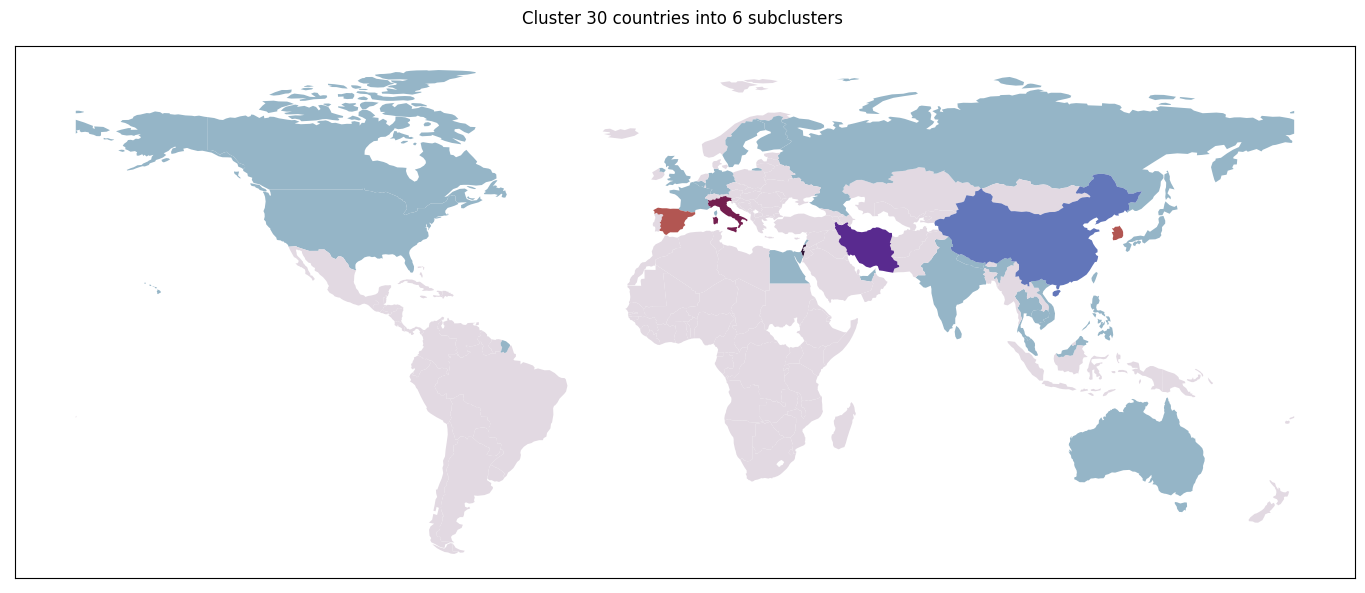

In [30]:
title = f'Cluster 30 countries into {num_clusters} subclusters'

fig, axes = plt.subplots(figsize=(15, 6))

world_geoframe.plot(column='clusters', ax=axes, cmap='twilight', vmin=0, vmax=8)

axes.grid(False)
axes.set_xticks([])
axes.set_yticks([])

fig.suptitle(title)
fig.tight_layout()

fig.savefig('../figures/world_map.png')

# Output files

In [31]:
data_gradient.to_csv('../results/data_gradient.csv')

data_1date_trunc.to_csv('../results/data_1date_trunc.csv')
data_2date_trunc.to_csv('../results/data_2date_trunc.csv')
data_5date_trunc.to_csv('../results/data_5date_trunc.csv')
data_1day_trunc.to_csv('../results/data_1day_trunc.csv')
data_2day_trunc.to_csv('../results/data_2day_trunc.csv')
data_5day_trunc.to_csv('../results/data_5day_trunc.csv')

data_1date_low.to_csv('../results/data_1date_low.csv')
data_2date_low.to_csv('../results/data_2date_low.csv')
data_5date_low.to_csv('../results/data_5date_low.csv')
data_1day_low.to_csv('../results/data_1day_low.csv')
data_2day_low.to_csv('../results/data_2day_low.csv')
data_5day_low.to_csv('../results/data_5day_low.csv') 

linkage_matrix1.to_csv('../results/linkage_matrix1.csv')
linkage_matrix2.to_csv('../results/linkage_matrix2.csv')
linkage_matrix1b.to_csv('../results/linkage_matrix1b.csv')
linkage_matrix2b.to_csv('../results/linkage_matrix2b.csv')
linkage_matrix3.to_csv('../results/linkage_matrix3.csv')
linkage_matrix4.to_csv('../results/linkage_matrix4.csv')
linkage_matrix5.to_csv('../results/linkage_matrix5.csv')

world_geoframe.to_csv('../results/world_geoframe.csv')